<a href="https://colab.research.google.com/github/anamarijaeres/Analysis-of-the-Relationship-between-Movie-Titles-and-Corresponding-Ratings-and-Reviews/blob/main/NLP_Word_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/gdrive")

Mounted at /gdrive


In [ ]:
dataset = '/gdrive/My Drive/NLP-filmovi/Dataset/'
movie_names = ["2012", "A Beautiful Mind", "Amadeus", "Avatar", "Clash of the Titans", "Les Miserables", "Star Wars Episode I - The Phantom Menace", "The Expendables I", "The Godfather", "The Matrix Revolutions"]
reviews = []
polarities = []
ratings = []

In [ ]:
for index in range(len(movie_names)):
  reviews_for_certain_movie = []
  for i in range(1,101):
    with open(dataset + movie_names[index] + "/" + str(i) +".txt", 'r') as f:
      reviews_for_certain_movie.append(f.read())
  with open(dataset + movie_names[index] + "/" + "polarity.txt", 'r') as polarity:
    polarities.append(polarity.read()[12:-1].split(","))
  with open(dataset + movie_names[index] + "/" + "rating.txt", 'r') as rating:
    ratings.append(rating.read()[11:-2].split(" , "))  
  reviews.append(reviews_for_certain_movie)

In [ ]:
# Provjera za spremljene reviewove
for movie_number, review in enumerate(reviews[:2]):
  print("Reviews for the movie " + movie_names[movie_number] + ": \n")
  [print(x) for x in review]
  print("\n\n\n\n")

In [ ]:
# Provjera za spremljeni polaritet i rating
for polarity_number, polarity in enumerate(polarities):
  print("Polarity number: " + str(polarity_number))
  print("Review: " + str(polarity))
for rating_number, rating in enumerate(ratings):
  print("Rating number: " + str(rating_number))
  print("Rating: " + str(rating))

In [ ]:
# Word Embedding
import io
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

In [ ]:
# Priprema podataka za Keras model
batch_size = 512
seed = 321
train_ds = tf.data.Dataset.from_tensor_slices((np.asarray(reviews[:8]), np.asarray(polarities[:8], dtype=np.int_)))
val_ds = tf.data.Dataset.from_tensor_slices((np.asarray(reviews[8:]), np.asarray(polarities[8:], dtype=np.int_)))
print(train_ds)
print(val_ds)

<TensorSliceDataset shapes: ((100,), (100,)), types: (tf.string, tf.int64)>
<TensorSliceDataset shapes: ((100,), (100,)), types: (tf.string, tf.int64)>


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 100

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [ ]:
embedding_dim=8

model = Sequential([
  vectorize_layer,
  Embedding(vocab_size, embedding_dim, name="embedding"),
  GlobalAveragePooling1D(),
  Dense(16, activation='relu'),
  Dense(1)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15)

Epoch 1/15
8/8 [==============================] - 1s 38ms/step - loss: 0.6903 - accuracy: 0.2612 - val_loss: 0.6826 - val_accuracy: 0.1750
Epoch 2/15
8/8 [==============================] - 0s 15ms/step - loss: 0.6826 - accuracy: 0.2612 - val_loss: 0.6717 - val_accuracy: 0.1750
Epoch 3/15
8/8 [==============================] - 0s 13ms/step - loss: 0.6744 - accuracy: 0.2612 - val_loss: 0.6598 - val_accuracy: 0.1750
Epoch 4/15
8/8 [==============================] - 0s 13ms/step - loss: 0.6656 - accuracy: 0.2612 - val_loss: 0.6472 - val_accuracy: 0.1750
Epoch 5/15
8/8 [==============================] - 0s 13ms/step - loss: 0.6565 - accuracy: 0.2612 - val_loss: 0.6339 - val_accuracy: 0.1750
Epoch 6/15
8/8 [==============================] - 0s 14ms/step - loss: 0.6469 - accuracy: 0.2612 - val_loss: 0.6198 - val_accuracy: 0.1750
Epoch 7/15
8/8 [==============================] - 0s 13ms/step - loss: 0.6370 - accuracy: 0.2612 - val_loss: 0.6053 - val_accuracy: 0.1750
Epoch 8/15
8/8 [===========

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 100, 8)            80000     
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-traina

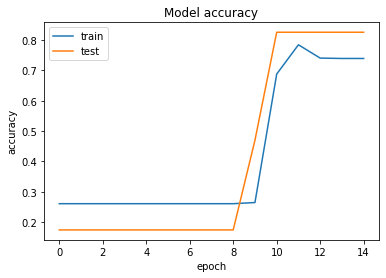

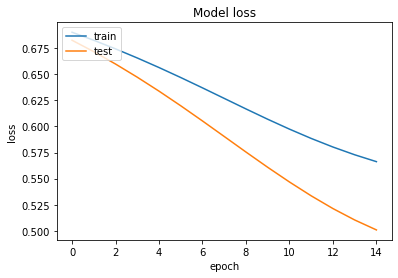

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [ ]:
out_v = io.open('vectorsNLP.tsv', 'w', encoding='utf-8')
out_m = io.open('metadataNLP.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()